In [1]:
%load_ext autoreload
%autoreload 2
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import scanpy_helpers.de as de
from scanpy_helpers.annotation import AnnotationHelper
from warnings import filterwarnings
from pygenesig.gini import GiniSignatureGenerator

sc.settings.verbosity = 3

filterwarnings("ignore", category=FutureWarning)
sc.set_figure_params(figsize=(5, 5))
import re

In [2]:
output_dir = "../../data/50_myeloid_cells/30_de_analysis"

In [3]:
adata = sc.read_h5ad(
    "../../data/50_myeloid_cells/20_cell_type_annotation/adata_annotated.h5ad"
)
adata_scvi = sc.read_h5ad(
    "../../data/50_myeloid_cells/01_myeloid_subset/adata_scvi.h5ad"
)

The two anndata objects are the same, except `adata` contains log-normalized counts and the cell-type annotations, whereas `adata_scvi` just contains the raw counts

In [4]:
assert adata.shape == adata_scvi.shape

## DE analysis

According to [this benchmark](https://pubmed.ncbi.nlm.nih.gov/29481549/), edgeR and MAST are among the best methods for 
DE analysis of single cells. In any case, the authors recommend to include the number of detected genes into the model. 
Moreover, the model needs to correct for batch effects arising from different patients and dataset:

      `~ 1 + cell_type + sample + n_genes`. 

I tried different approaches for DE analysis:

* `edgeR` way too slow given the number of cells and categories. Aborted after 72h. 
* `glmGamPoi` claims to be a faster version of edge R. Completed after 6 hours on a subset of 500 cells. Still way too slow. 
* `scVI` provides a method for batch-corrected differential expression analysis based on the same autoencode used for integrating the data. It is very fast (few minutes) and their [preprint claims](https://www.biorxiv.org/content/10.1101/794289v1) superior performance over MAST and edgeR. 
* `MAST`, while being slower than `scVI` is also based on a linear model. It can be massively parallelized and completed on the entire dataset in 2:30h on 44 cores. 

In the following I will show the results of `scVI` and `MAST`. 

### scVI

In [5]:
adata_scvi.obs["cell_type"] = adata.obs["cell_type"]
scvi.data.setup_anndata(adata_scvi, batch_key="sample")
model = scvi.model.SCVI.load(f"../../data/50_myeloid_cells/20_cell_type_annotation/scvi_model_all_genes", adata_scvi)

# try to load from cache
try:
    scvi_res = pd.read_csv(f"{output_dir}/scvi_res.csv")
except FileNotFoundError:    
    scvi_res = de.scvi(adata_scvi, model, groupby="cell_type")
    scvi_res.to_csv(f"{output_dir}/scvi_res.csv")

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/data/scratch/sturm/conda/envs/2021-nsclc_heterogeneity-scanpy/lib/python3.8/site-packages/scvi/data/_anndata.py:709: UserWarning: Category 6 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  warnings.warn(


INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 15817 cells, 17567 vars, 80       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/data/scratch/sturm/conda/envs/2021-nsclc_heterogeneity-scanpy/lib/python3.8/site-packages/scvi/data/_anndata.py:709: UserWarning: Category 6 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  warnings.warn(


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 15817 cells, 17567 vars, 80       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


### MAST

In [6]:
%%time
try:
    mast_res = pd.read_csv(f"{output_dir}/mast_res.csv")
except FileNotFoundError:
    mast_res = de.mast(
        adata,
        groupby="cell_type",
        cofactors=["sample", "n_genes"],
        n_jobs=16,
        n_cores_per_job=4,
    )
    mast_res.to_csv(f"{output_dir}/mast_res.csv")

CPU times: user 163 ms, sys: 15.3 ms, total: 178 ms
Wall time: 177 ms


## DE Results



## scVI

* scVI uses logBayesFactor as main output statistic. The log bayes factors are to be interpreted as described [here](https://docs.scvi-tools.org/en/stable/user_guide/notebooks/scVI_DE_worm.html#Interpreting-Bayes-factors). `proba_not_de` can be interpreted as a FDR-corrected p-value. 
* a lot of the top hits that are very sparsely expressed in one cell-type and not at all in the other cell-types. While the signal is probably real, these genes are still bad candidate markers as they are hardly expressed. Below is an example of "TEX11" which is expressed in 8 cells in total - 7 of them are DC Lagerhans. 
* Alternatively, I rank genes by their log-fold change require the minimum expression to be >= 0.5

### TEX11 is a top hit, but a bad marker

In [21]:
adata.obs["_TEX11"] = (adata[:, "TEX11"].X.todense().A1 > 0).astype(str)

... storing '_TEX11' as categorical


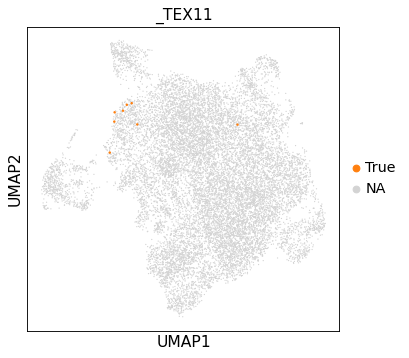

In [22]:
sc.pl.umap(adata, color="_TEX11", groups="True", size=[20 if x == "True" else 5 for x in adata.obs["_TEX11"]])

In [9]:
scvi_res

,Unnamed: 0,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
0,S100B,0.988911,0.011089,4.490676,0.003340,2.282279e-04,4.393522,4.311810,2.316822,-4.965695,15.105190,384.165064,15.642730,0.892628,0.211018,34.357274,1.753272,True,DC Lagerhans vs Rest
1,TEX11,0.988105,0.011895,4.419656,0.000008,5.724059e-07,4.658655,4.419306,2.944300,-6.919409,28.838980,0.011218,0.000197,0.009615,0.000132,0.009212,0.001158,True,DC Lagerhans vs Rest
2,CACNA1G-AS1,0.986492,0.013508,4.290868,0.000002,1.260032e-07,4.294098,4.165443,2.584644,-5.035019,19.826138,0.091346,0.003423,0.014423,0.000197,0.012735,0.000038,True,DC Lagerhans vs Rest
3,CD1A,0.985282,0.014718,4.203874,0.000806,6.945911e-05,4.073911,3.971226,2.178431,-3.995603,15.659993,159.200321,2.108142,0.596154,0.062595,6.764472,0.208127,True,DC Lagerhans vs Rest
4,LTB,0.985282,0.014718,4.203874,0.003367,1.634798e-04,4.343697,4.347876,2.261448,-2.376017,13.067993,300.549679,12.958928,0.940705,0.246693,25.005434,1.306680,True,DC Lagerhans vs Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193232,ST13,0.493750,0.506250,-0.025001,0.000189,1.783504e-04,0.097848,0.071920,0.420828,-1.565603,3.784390,30.137209,14.026841,0.795349,0.657243,1.790160,1.840915,False,myeloid dividing vs Rest
193233,OAZ1,0.492944,0.507056,-0.028228,0.001902,1.762684e-03,0.131977,0.112570,0.405791,-1.553630,2.950152,771.234884,395.660948,0.988372,0.980763,19.984114,18.899690,False,myeloid dividing vs Rest
193234,CDC42,0.479435,0.520565,-0.082304,0.000417,4.106994e-04,0.045006,0.040743,0.395459,-1.776651,3.129409,108.669767,50.481055,0.918605,0.843114,3.876184,4.205143,False,myeloid dividing vs Rest
193235,EDF1,0.464919,0.535081,-0.140554,0.000355,3.733420e-04,-0.061367,-0.069788,0.374877,-1.687408,1.817972,97.825581,55.650484,0.939535,0.833691,3.995501,3.870598,False,myeloid dividing vs Rest


### alternative scoring strtegy

In [33]:
scvi_res["score"] = scvi_res["lfc_mean"] * (scvi_res["raw_normalized_mean1"] > .5)
# de_res["score"] = de_res["bayes_factor"] * (de_res["raw_normalized_mean2"] - de_res["raw_normalized_mean1"]) * -1

In [34]:
scvi_res["cell_type"] = [x.split("vs")[0].strip() for x in scvi_res["comparison"]]

In [35]:
de.de_res_to_anndata(
    adata,
    scvi_res,
    groupby="cell_type",
    gene_id_col="Unnamed: 0",
    pval_col="proba_not_de",
    pval_adj_col="proba_not_de",
    lfc_col="lfc_mean",
)

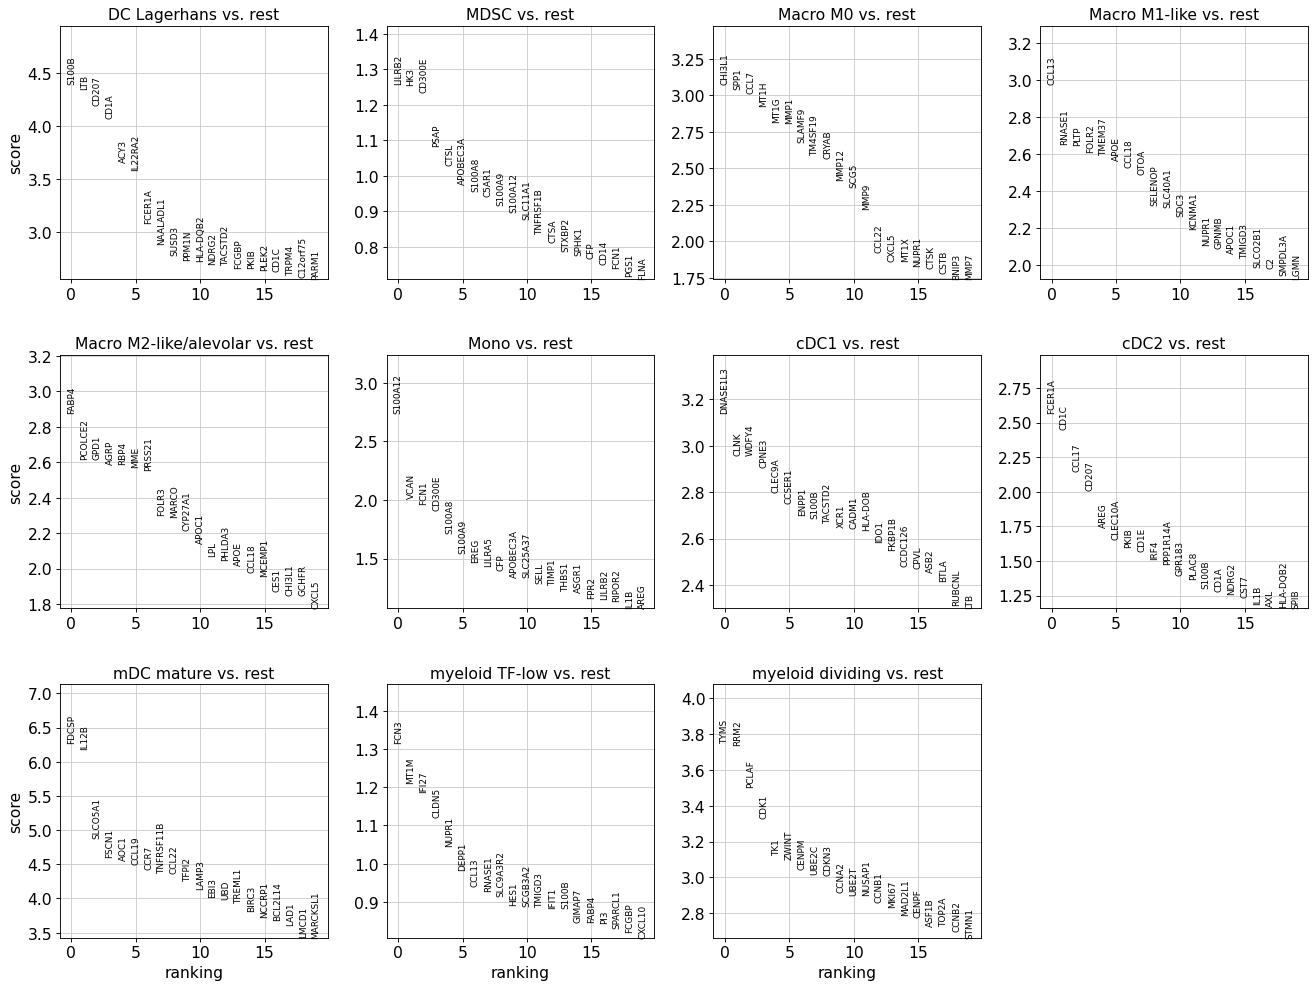

In [36]:
sc.pl.rank_genes_groups(adata, sharey=False)

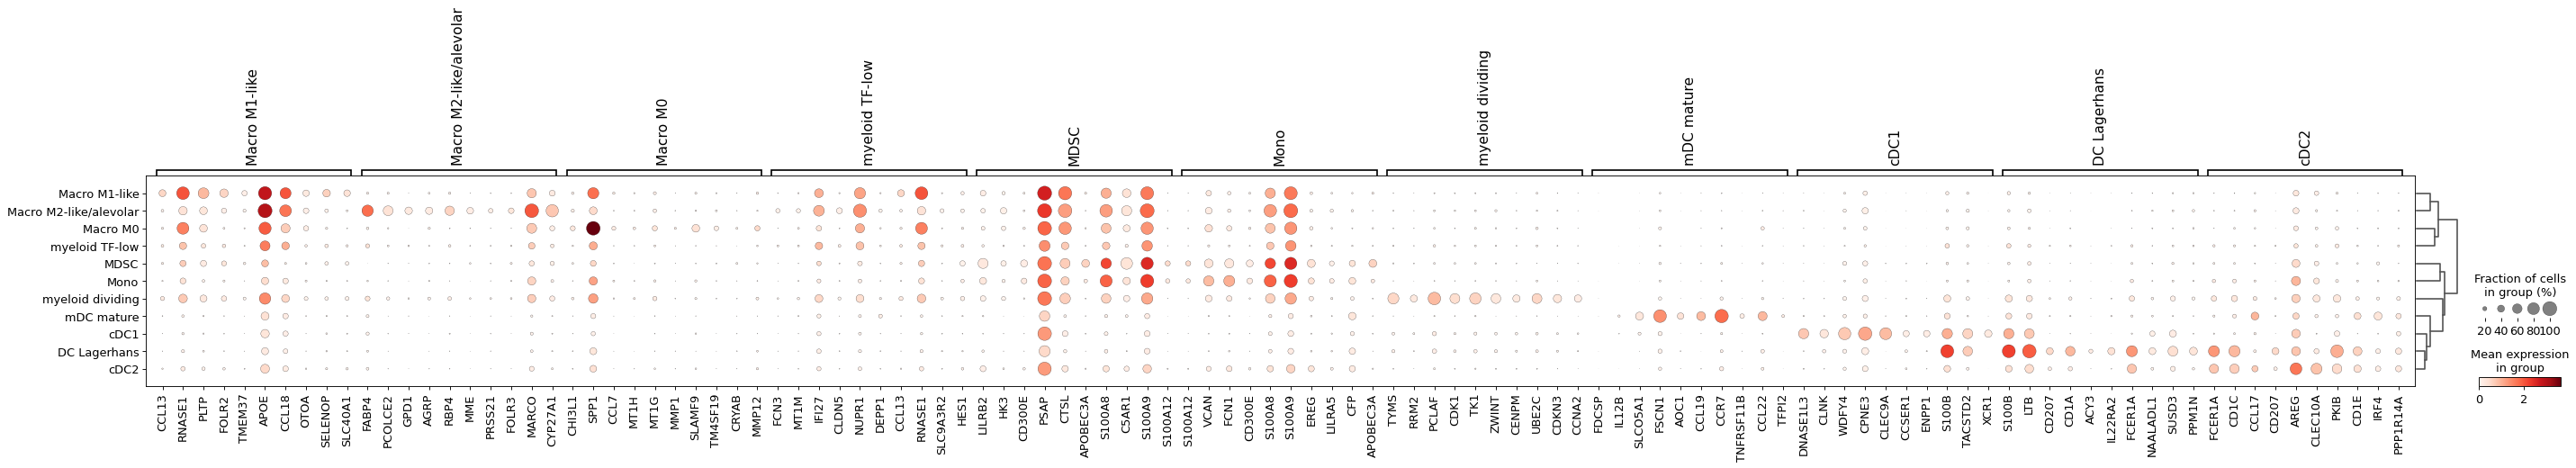

In [37]:
sc.pl.rank_genes_groups_dotplot(adata)

On first glance, the markers make sense: 

* CCR7 is the marker that was used for classifying mDC mature in the first place
* CDK1 is a marker for dividing cells
* Visual inspection of the top hits on UMAP are clearly restricted to a subset of cells (see "Plots" section at the end of the notebook) 

## MAST

 * Due to the immense statistical power arising from 15k cells, almost all differences between cells become statistically significant. In fact many comparisons hava a p-value of 0. 
 * Ranking by p-value (only) is therefore not viable to find marker genes. Ranking by log-fold change instead

In [ ]:
# de_res["group"] = [re.search(r"cell_type(.+?)\)", x.split('-')[1]).group(1) for x in de_res["comparision"]]

In [38]:
mast_res["cell_type"] = mast_res["comparison"]
mast_res.loc[mast_res["coef"].isnull(), "coef"] = 0
mast_res.loc[mast_res["Pr(>Chisq)"] == 0, "Pr(>Chisq)"] = np.min(
    mast_res["Pr(>Chisq)"][mast_res["Pr(>Chisq)"] != 0]
)
mast_res["score"] = mast_res["coef"]

In [42]:
mast_res.sort_values("score")

,Unnamed: 0,primerid,Pr(>Chisq),coef,comparison,cell_type,score
51235,51236,TYROBP,1.002953e-321,-2.464660,cDC1,cDC1,-2.464660
149927,149928,MTCO1P21,3.215264e-116,-2.121543,myeloid_TF_low,myeloid_TF_low,-2.121543
163638,163639,FTL,5.568892e-126,-1.922741,mDC_mature,mDC_mature,-1.922741
113947,113948,LYZ,1.002953e-321,-1.921086,DC_Lagerhans,DC_Lagerhans,-1.921086
106356,106357,APOC1,1.071573e-124,-1.907300,DC_Lagerhans,DC_Lagerhans,-1.907300
...,...,...,...,...,...,...,...
127898,127899,FABP4,1.002953e-321,1.929553,Macro_M2_like_alevolar,Macro_M2_like_alevolar,1.929553
174183,174184,TXN,1.002953e-321,2.135050,mDC_mature,mDC_mature,2.135050
62092,62093,MTCO1P21,1.327029e-80,2.193949,Macro_M1_like,Macro_M1_like,2.193949
38648,38649,CST3,1.002953e-321,2.403654,cDC1,cDC1,2.403654


In [43]:
adata.obs["cell_type"] = de._make_names(adata.obs["cell_type"])

In [45]:
de.de_res_to_anndata(
    adata,
    mast_res,
    groupby="cell_type",
    gene_id_col="primerid",
    pval_col="Pr(>Chisq)",
    lfc_col="coef",
    score_col="coef",
)

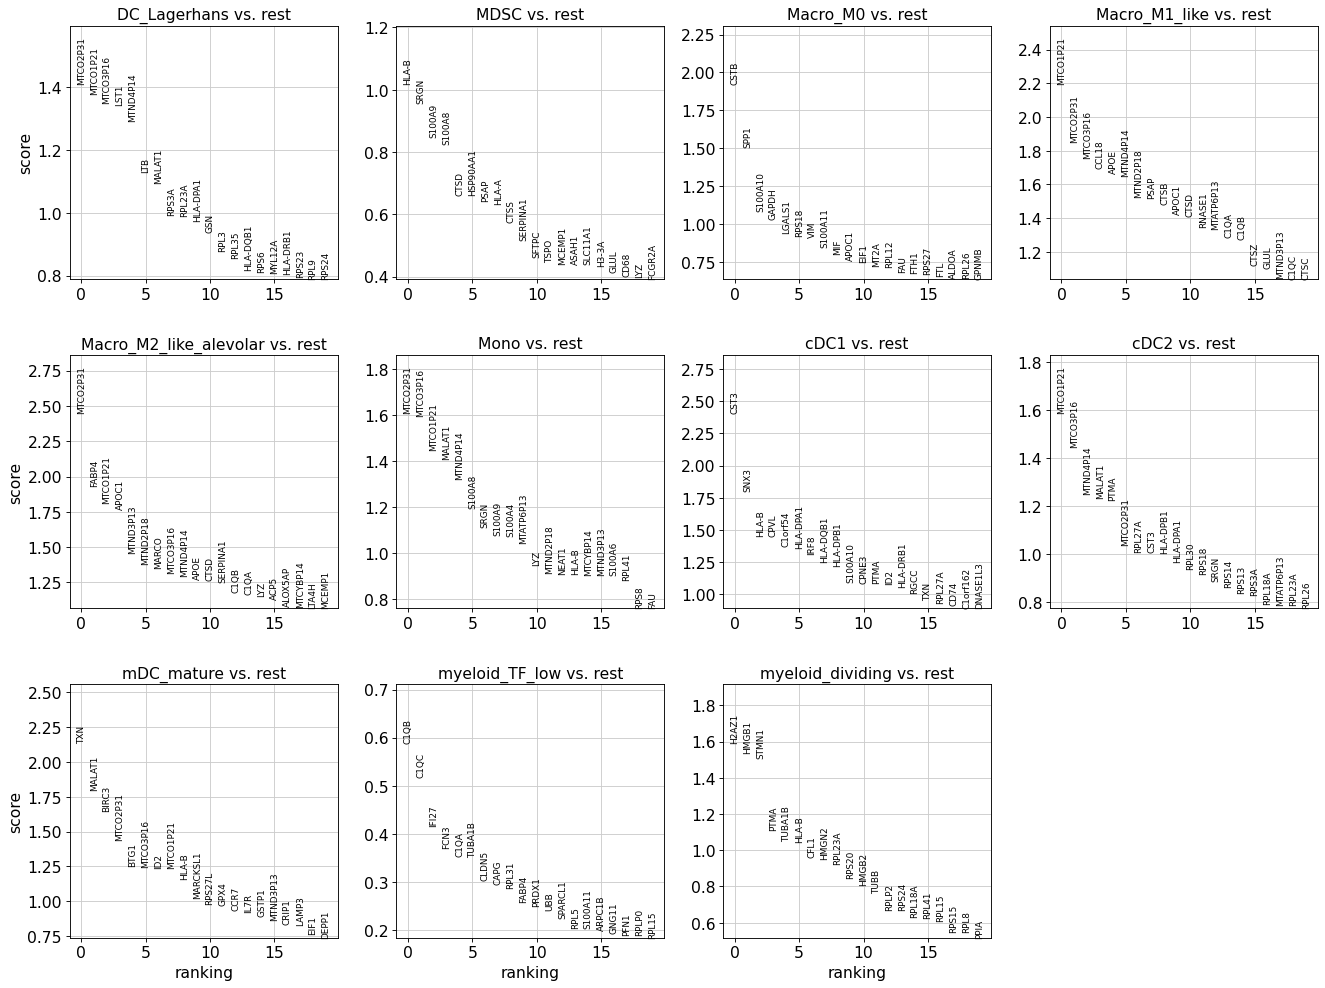

In [46]:
sc.pl.rank_genes_groups(adata, sharey=False)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


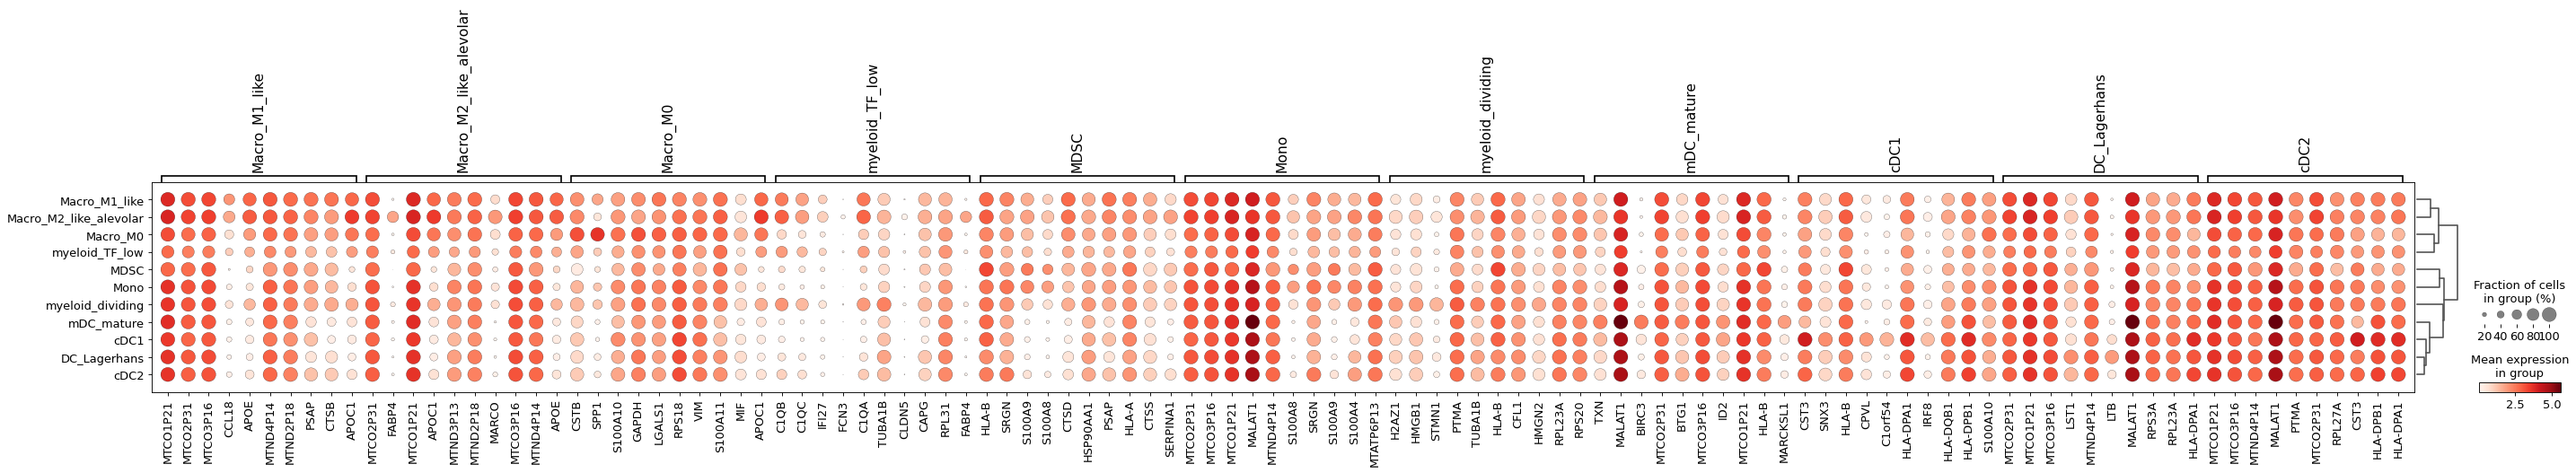

In [49]:
sc.tl.dendrogram(adata, groupby="cell_type")
sc.pl.rank_genes_groups_dotplot(adata)

## Plot marker genes

### Plot the cibersort/xCell scores by cell-type

In [ ]:
for tmp_adata in [
    adata,
    adata[
        adata.obs["cell_type"].str.startswith("Macro"),
    ],
]:
    sc.pl.dotplot(
        tmp_adata,
        var_names=[
            "TF:MYC",
            "TF:SPI1",
            "TF:STAT1",
            "TF:NFKB1",
            "cibersort Macrophage M0",
            "cibersort Macrophage M1",
            "cibersort Macrophage M2",
            "cibersort Monocyte",
            "xcell Monocyte",
            "xcell Macrophage M1",
            "xcell Macrophage M2",
            "xcell Macrophage",
        ],
        groupby="cell_type",
        standard_scale="var",
        swap_axes=True,
    )

## Cell-type markers

In [ ]:
sc.pl.umap(adata, color="C1QB")

In [ ]:
sc.pl.umap(adata, color=["CCL17", "CCL13", "FABP4", "SPP1", "SLAMF9"], cmap="inferno")